The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [157]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
from IPython.display import display, clear_output

In [159]:
import sys
sys.path.append('../../..')

In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [161]:
from magrec.misc.load import load_matlab_data

Loaded data of shape (4, 125, 55), padded up to torch.Size([4, 125, 55]), with spacing dx = 0.020 μm, dy = 0.029 μm


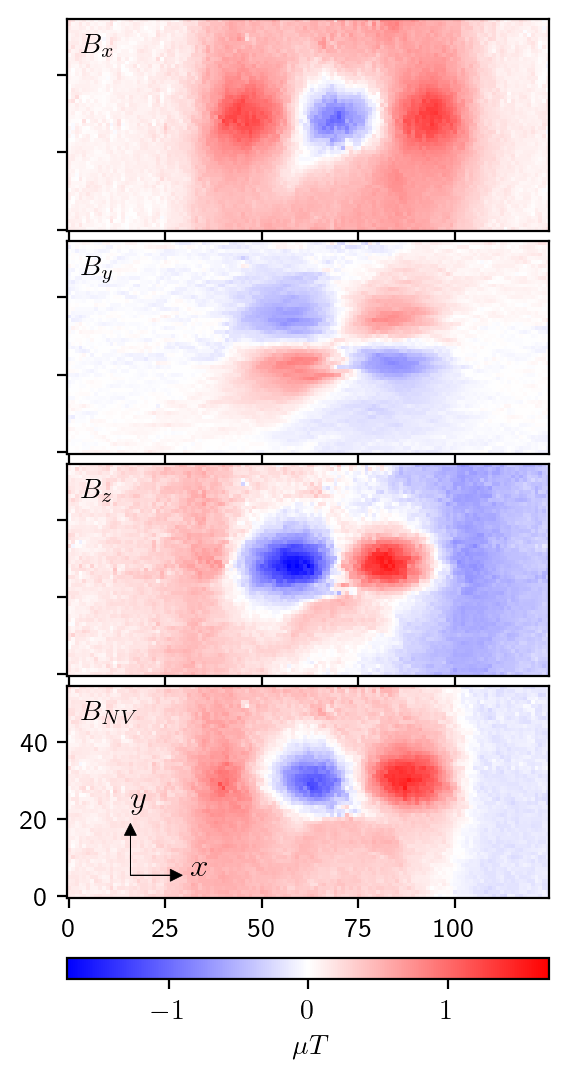

In [162]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0)
original_shape = B.shape

# make roi slice obejct out of the original shape, assuming the data starts at (0, 0)
roi_original = (slice(None), slice(original_shape[-2]), slice(original_shape[-1]))

B = B * 1e6 # convert to μT

B = torch.tensor(B, dtype=torch.float32)

# find mean spacing between points, assuming uniform (more or less) grid
dx = np.diff(mat['rx_inv']).mean()
dy = np.diff(mat['ry_inv']).mean()

print(f'Loaded data of shape {original_shape}, padded up to {B.shape}, with spacing dx = {dx:.3f} μm, dy = {dy:.3f} μm')

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

# Show how the data looks like
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

# Neural net architecture

In [7]:
class CNN(nn.Module):
    # class to create a convolutionnal neural network for magnetisation reconstruction

    def __init__(self, Size=2, ImageSize=256, kernel = 5, stride = 2, padding = 2, channels_in = 1, channels_out=1):
        super().__init__()

        M = Size

        if ImageSize == 512:
            ConvolutionSize = 32
        elif ImageSize == 256:
            ConvolutionSize = 16
        else: # size is 128
            ConvolutionSize = 8
        # first index is the number of channels
        self.convi = nn.Conv2d(channels_in, 8*M, kernel, 1, padding)
        self.conv_r0 = nn.Conv2d(1, 8*M, kernel, 1, padding)
        self.conv1 = nn.Conv2d(8*M, 8*M, kernel, stride, padding)
        self.bn1  = nn.BatchNorm2d(8*M)
        self.conv2 = nn.Conv2d(8*M, 16*M, kernel, stride, padding)
        self.bn2  = nn.BatchNorm2d(16*M)
        self.conv3 = nn.Conv2d(16*M, 32*M, kernel, stride, padding)
        self.bn3  = nn.BatchNorm2d(32*M)
        self.conv4 = nn.Conv2d(32*M, 64*M, kernel, stride, padding)
        self.bn4  = nn.BatchNorm2d(64*M)

        self.conv5 = nn.Conv2d(64*M, 128*M, 5, 1, 2)
        self.bn5  = nn.BatchNorm2d(128*M)

        # add extra BatchNorm2d layers, to avoid reusing them from the encoder part above
        self.trans1 = nn.ConvTranspose2d(128 * M, 64 * M, kernel, stride, padding, 1)
        self.bn4t = nn.BatchNorm2d(64 * M)
        self.trans2 = nn.ConvTranspose2d(64 * M + 32 * M, 32 * M, kernel, stride, padding, 1)
        self.bn3t = nn.BatchNorm2d(32 * M)
        self.trans3 = nn.ConvTranspose2d(32 * M + 16 * M, 16 * M, kernel, stride, padding, 1)
        self.bn2t = nn.BatchNorm2d(16 * M)
        self.trans4 = nn.ConvTranspose2d(16 * M + 8 * M, 8 * M, kernel, stride, padding, 1)
        self.bn1t = nn.BatchNorm2d(8 * M)
        self.conv6 = nn.Conv2d(8*M, channels_out, kernel, 1, padding)
        self.conv7 = nn.Conv2d(channels_out, channels_out, kernel, 1, padding)

        self.fc11 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc12 = nn.Linear(120, 84)
        self.fc13 = nn.Linear(84, 1)

        self.fc21 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc22 = nn.Linear(120, 84)
        self.fc23 = nn.Linear(84, 1)

        self.fc31 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc32 = nn.Linear(120, 84)
        self.fc33 = nn.Linear(84, 1)

        self.fc41 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc42 = nn.Linear(120, 84)
        self.fc43 = nn.Linear(84, 1)

        self.fc51 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc52 = nn.Linear(120, 84)
        self.fc53 = nn.Linear(84, 1)

        self.transfc1 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.transfc2 = nn.Linear(120, 256)
        self.transfc3 = nn.Linear(256, 65536)

    def forward(self,input,
                roi,
                Nv_theta=False,
                Nv_phi=False,
                Nv_Height=False,
                M_angle=False,
                PositiveCurrentOnly = False,):

        conv0 = self.convi(input)
        roi0 = self.conv_r0(roi)
        mask = roi * conv0
        conv0 = F.leaky_relu(mask, 0.2)
        conv1 = F.leaky_relu(self.bn1(self.conv1(conv0)), 0.2)
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), 0.2)
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), 0.2)
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), 0.2)

        conv5 = F.leaky_relu(self.conv5(conv4), 0.2)

        trans1 = F.leaky_relu(self.bn4t(self.trans1(conv5)), 0.2)
        trans2 = F.leaky_relu(self.bn3t(self.trans2(torch.cat([conv3,trans1], dim=1))), 0.2)
        trans3 = F.leaky_relu(self.bn2t(self.trans3(torch.cat([conv2,trans2], dim=1))), 0.2)
        trans4 = F.leaky_relu(self.bn1t(self.trans4(torch.cat([conv1,trans3], dim=1))), 0.2)

        conv6 = self.conv6(trans4)
        conv7 = self.conv7(conv6)
        
        if PositiveCurrentOnly is True:
            conv8 = F.relu(conv7)
        else:
            conv8 = (conv7)
        
        # CurrentTheta = torch.flatten(conv4, 1)
        # CurrentTheta = F.leaky_relu(self.fc11(CurrentTheta), 0.)
        # CurrentTheta = F.leaky_relu(self.fc12(CurrentTheta), 0.)
        # CurrentTheta = (self.fc13(CurrentTheta))

        # CurrentPhi = torch.flatten(conv4, 1)
        # CurrentPhi = F.leaky_relu(self.fc21(CurrentPhi), 0.)
        # CurrentPhi = F.leaky_relu(self.fc22(CurrentPhi), 0.)
        # CurrentPhi = (self.fc23(CurrentPhi))

        # NVTheta = torch.flatten(conv4, 1)
        # NVTheta = F.leaky_relu(self.fc31(NVTheta))
        # NVTheta = F.leaky_relu(self.fc32(NVTheta))
        # NVTheta = self.fc33(NVTheta).abs()

        # NVPhi = torch.flatten(conv4, 1)
        # NVPhi = F.leaky_relu(self.fc41(NVPhi))
        # NVPhi = F.leaky_relu(self.fc42(NVPhi))
        # NVPhi = self.fc43(NVPhi)

        # # MInt as in M intensity (?) a scalar for each sample — MF.
        # JInt = torch.flatten(conv4, 1)
        # JInt = F.leaky_relu(self.fc51(JInt))
        # JInt = F.leaky_relu(self.fc52(JInt))
        # JInt = self.fc53(JInt)
        # JInt = torch.abs(JInt) 
        
        conv9 = conv8

        return conv9
        return JInt, conv9, CurrentTheta, CurrentPhi, NVTheta, NVPhi

In [187]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet

In [194]:
from magrec.scripts.prototype_pipeline import Prototype

In [288]:
pipe = Pipe([
    ('gaussian_filter', GaussianFilter(2.0)),
    ('plot1', PlotResults()),
    ('B_NV', Function(lambda x: x[None, 0:1, :, :])),
    ('padded_B_NV', Padder(up_to=(16*10, 16*8))),
])

model = Pipe([
    ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[:, 0:1, :, :])),
])

recon = Prototype(net=UNet, model=model, pipe=pipe, max_epochs=20)

  epoch    train_loss       dur
-------  ------------  --------
      1      2.05e-01  1.74e-01
     20      1.39e-01  6.53e-02
     40      6.22e-03  1.23e-01
     60      8.60e-03  9.27e-02
     80      2.94e-03  5.81e-02
    100      1.06e-03  9.57e-02
    120      4.70e-04  6.63e-02
    140      2.89e-04  7.67e-02
    160      1.73e-04  6.06e-02
    180      1.21e-04  5.86e-02
    200      2.04e-04  7.53e-02


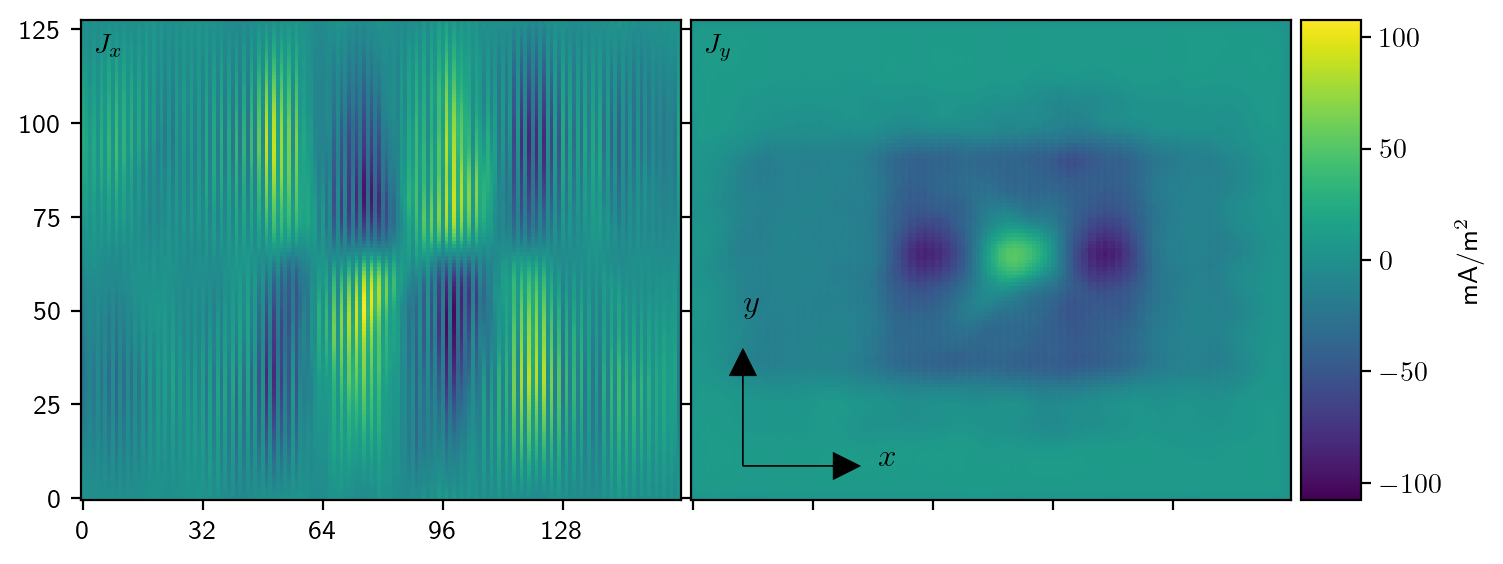

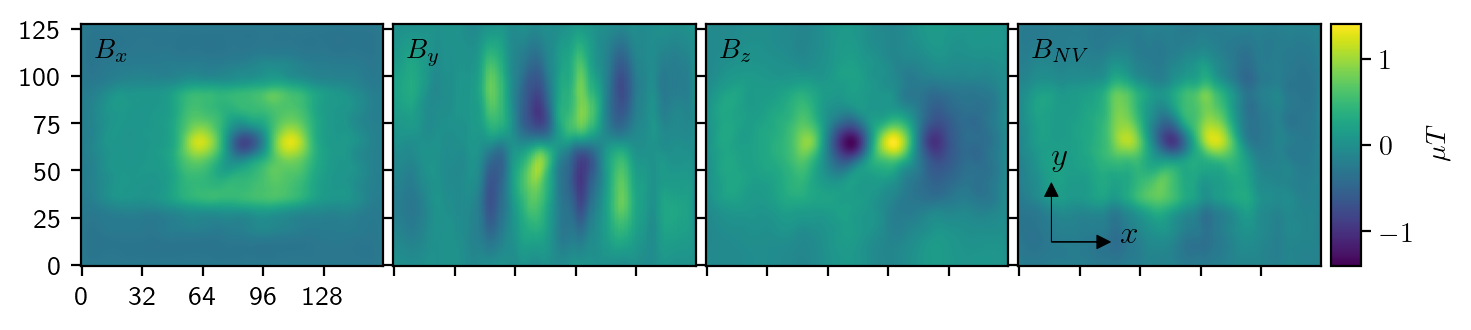

tensor([[[[-0.2259, -0.2359, -0.2473,  ..., -0.2449, -0.2328, -0.2239],
          [-0.2350, -0.2474, -0.2612,  ..., -0.2581, -0.2435, -0.2324],
          [-0.2431, -0.2576, -0.2733,  ..., -0.2681, -0.2514, -0.2390],
          ...,
          [-0.2291, -0.2408, -0.2519,  ..., -0.2461, -0.2329, -0.2240],
          [-0.2215, -0.2311, -0.2400,  ..., -0.2351, -0.2242, -0.2171],
          [-0.2195, -0.2282, -0.2368,  ..., -0.2332, -0.2230, -0.2162]]]],
       grad_fn=<SliceBackward0>)

In [289]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=1)

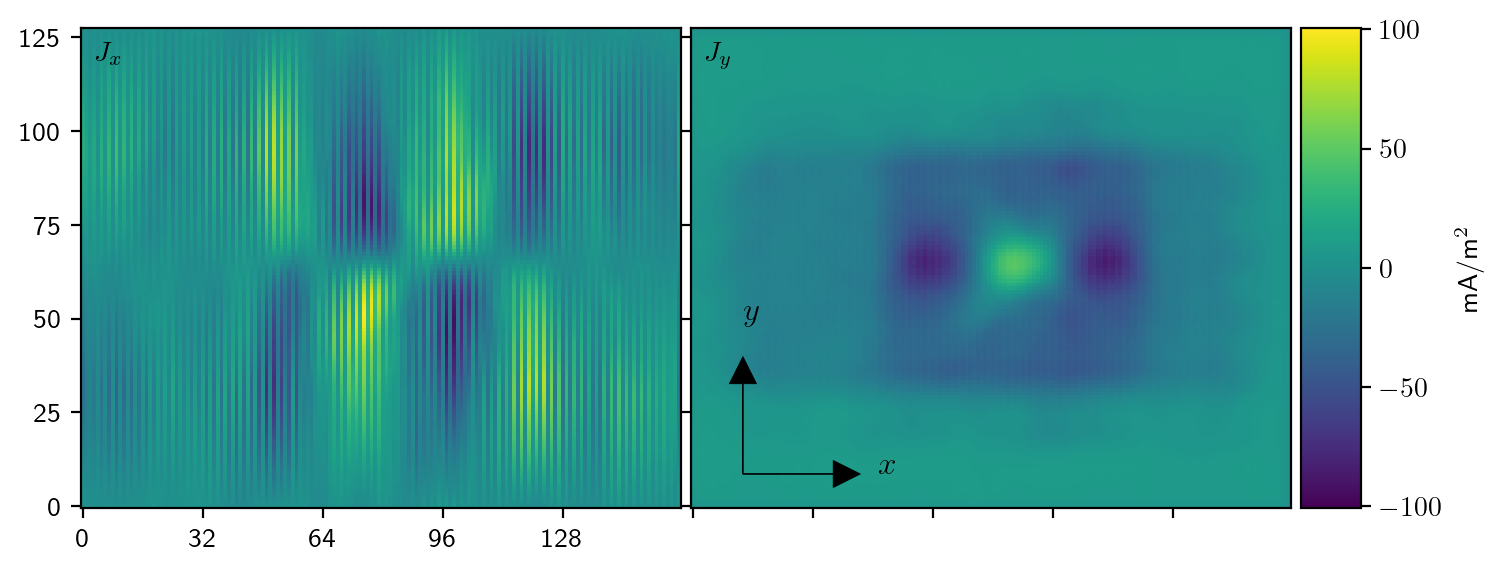

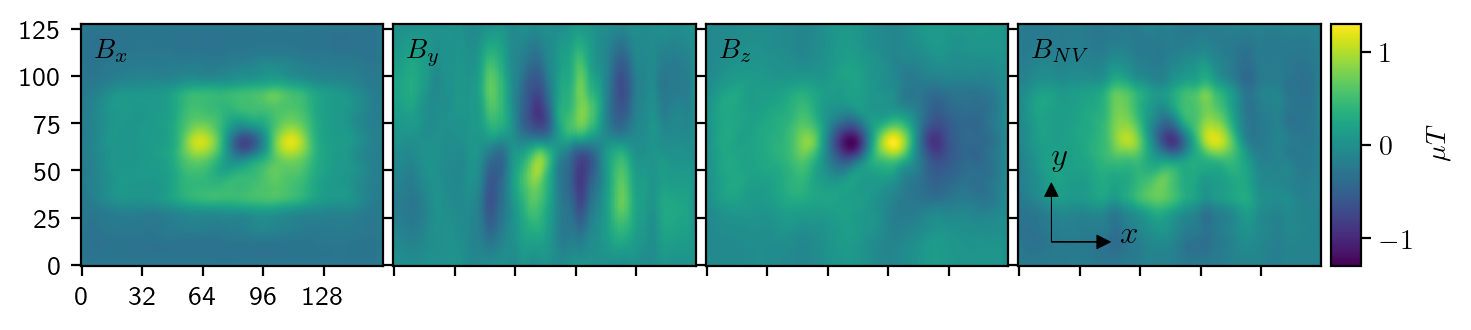

tensor([[[[-0.2188, -0.2287, -0.2399,  ..., -0.2376, -0.2257, -0.2168],
          [-0.2278, -0.2400, -0.2537,  ..., -0.2507, -0.2363, -0.2253],
          [-0.2357, -0.2501, -0.2655,  ..., -0.2606, -0.2440, -0.2317],
          ...,
          [-0.2217, -0.2333, -0.2442,  ..., -0.2385, -0.2255, -0.2167],
          [-0.2143, -0.2237, -0.2324,  ..., -0.2276, -0.2169, -0.2099],
          [-0.2124, -0.2209, -0.2294,  ..., -0.2259, -0.2159, -0.2091]]]],
       grad_fn=<SliceBackward0>)

In [294]:
recon.propagate(B, epochs=0)